# variational Latent Gaussian Process

This tutorial shows how to use the code to reproduce part of the result in the paper.

Import modules.

In [1]:
import os
from os import path as op

import numpy as np
from scipy import stats
from scipy import linalg

import vlgp
from vlgp import util, simulation

Then import and set up graphics. Borrow the palette from seaborn. 

In [2]:
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Create the paths to the data and ouput directories. These two subdirectories are expected to exist in current directory.

In [3]:
datapath = op.abspath('../data')
outputpath = op.abspath('../output')

## Lorenz Dynamics

We simulate a dataset driven by 3-dimensional Lorenz dynamics defined by the following differential equations,
\begin{align} 
    x_1' &= \sigma(x_2 - x_1)     \\
    x_2' &= x_1(\rho - x_3) - x_2 \\
    x_3' &= x_1 x_2 - \beta x_3.
\end{align}

Each sample consists of 10 trials of 50 spike trains. Each trial contains 1000 time bins. The discrete latent dynamics are sampled with the time step of 0.0015. The parameters are set to $\sigma=10$, $\rho=28$ and $\beta=2.667$. We normalize the dynamics and discard the first 2000 points to get stable result.

In [4]:
ntrial = 10  # number of trials
nbin = 1000  # number of time bins of each trial
nneuron = 50 # number of neurons (spike trains)
dim = 3 # latent dimension

To reproduce the same results as that in the paper, set the random seed and simulate 5 samples.

In [5]:
np.random.seed(0)
skip = 2000
lorenz = simulation.lorenz(skip +  ntrial * nbin, dt=1.5e-3, s=10, r=28, b=2.667, x0=np.random.random(3) * 2)
lorenz = (lorenz - lorenz.mean(axis=0)) / linalg.norm(lorenz, axis=0, ord=np.inf)
x = lorenz[skip:, :].reshape((ntrial, nbin, dim))  # latent dynamics in proper shape

Plot the first trial.

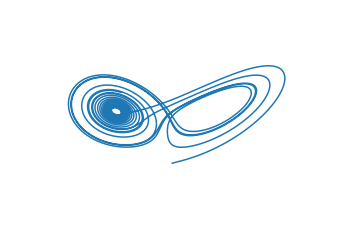

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*lorenz.T)
plt.axis("off")
plt.show()
plt.close()

Then simulate spike trains with 10-step history filter given the simulated latent dynamics. The elements of loading matrix is randomly generated from $(1, 2)$ with random signs. The base firing rate is 15Hz. 

The simulation function `simulation.spike` gives spike trains, design matrix of regression part and the true firing rates. We sort the loading matrix by row.

In [7]:
np.random.seed(0)
bias = np.log(15 / nbin)  # log base firing rate
a = (np.random.rand(dim, nneuron) + 1) * np.sign(np.random.randn(dim, nneuron)) # loading matrix
b = np.vstack((bias * np.ones(nneuron), -10 * np.ones(nneuron), -10 * np.ones(nneuron), -3 * np.ones(nneuron), 
                  -3 * np.ones(nneuron), -3 * np.ones(nneuron), -3 * np.ones(nneuron), -2 * np.ones(nneuron),
                  -2 * np.ones(nneuron), -1 * np.ones(nneuron), -1 * np.ones(nneuron)))  # regression weights

y, _, rate = simulation.spike(x, a, b)
sample = dict(y=y, rate=rate, x=x, alpha=a, beta=b)
util.save(sample, op.join(datapath, 'lorenz.npy'))  # store the simulation

Load the first sample and plot the spike trains.

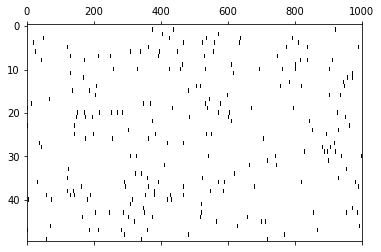

In [8]:
# Raster plot
plt.figure()
plt.spy(sample['y'][0, ...].T, aspect='auto')
plt.show()
plt.close()

### Model Fitting

Now let us do inference on the first sample. Firstly we need to set the random seed in order to get reproducible result because the algorithm does subsampling in the hyperparameters optimization steps. 

The `fit` function requires the observations, as a list of `dict` that represents a trial each. Each trial at least contains a identifier `ID` and the observation array `y` in the shape of `(bin, channel)`. 

In [9]:
np.random.seed(0)

trials = [{'ID': i, 'y': y} for i, y in enumerate(sample['y'])]  # make trials

fit = vlgp.fit(
    trials,  
    n_factors=3,  # latent dimensionality
    EMniter=20  # number of iterations
)

2019-01-30 15:22:42,983 - INFO - Started
constrain_loading : fro
constrain_latent : False
use_hessian : True
eps : 1e-08
tol : 1e-05
method : VB
learning_rate : 1.0
EMniter : 20
Eniter : 20
Mniter : 20
Hstep : True
da_bound : 5.0
db_bound : 5.0
dmu_bound : 5.0
omega_bound : (1e-05, 0.001)
window : 50
saving_interval : 1800
callbacks : []
2019-01-30 15:22:44,468 - INFO - Initialized
2019-01-30 15:22:59,380 - INFO - Iter 1, E step 7.80s, M step 1.37s.
2019-01-30 15:23:15,367 - INFO - Iter 2, E step 7.70s, M step 1.33s.
2019-01-30 15:23:30,672 - INFO - Iter 3, E step 7.73s, M step 1.36s.
2019-01-30 15:23:46,405 - INFO - Iter 4, E step 8.53s, M step 1.37s.
2019-01-30 15:24:00,158 - INFO - Iter 5, E step 8.37s, M step 1.41s.
2019-01-30 15:24:13,592 - INFO - Iter 6, E step 7.84s, M step 1.35s.
2019-01-30 15:24:27,396 - INFO - Iter 7, E step 7.79s, M step 1.35s.
2019-01-30 15:24:42,681 - INFO - Iter 8, E step 7.76s, M step 1.34s.
2019-01-30 15:24:55,567 - INFO - Iter 9, E step 7.74s, M step 1

The `fit` function returns a `dict` as the result containing `trials` which is a list of trials with the original observation and inferred latent states. The resulting `dict` also contains `parameter` where the parameters, such as the loading matrix and bias, are stored.

In [13]:
trials = fit['trials']  # extract trials
mu = np.stack(trial['mu'] for trial in trials) # extract posterior latent
mu = np.reshape(mu, (-1, dim))
W = np.linalg.lstsq(mu, x.reshape((-1, dim)))[0]
mu = mu @ W

/home/yuan/anaconda3/envs/vlgp/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


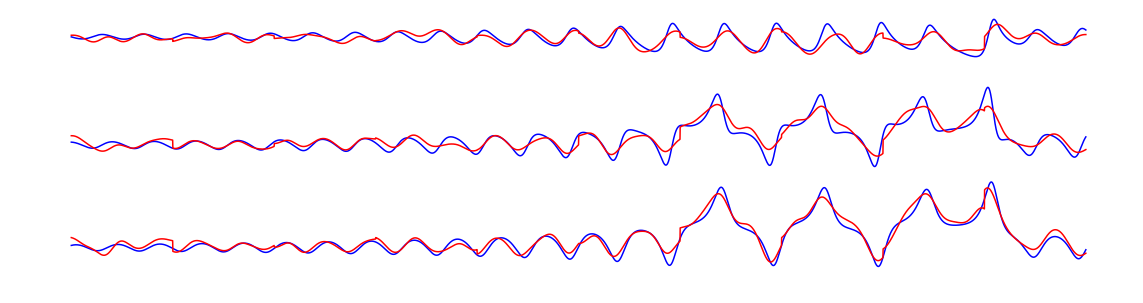

In [14]:
# Plot posterior latent
plt.figure(figsize=(20, 5))
plt.plot(x.reshape((-1, dim)) + 2 * np.arange(3), color="b")
plt.plot(mu + 2 * np.arange(3), color="r")
plt.axis("off")
plt.show()
plt.close()